# Imports and definitions

In [1]:
from XRDXRFutils.notebook_utils import *

### Base path ###
#path_shared = '/home/shared/'
path_shared = '../../shared/'

### Input ###
path_input = path_shared + 'dataXRDXRF/CappellaBrancacci/SpotXRD/'
path_multiple_points = path_input + 'grigi/'
file_calibration = path_input + 'calibration.ini'

list_path_database = [path_shared + 'Database16_42/']   # tabulated phases

### Output ###
subfolder_output = 'SpotResults/multiple/'
path_figures = subfolder_output + 'figures/'            # figures generated by the script

paths_to_create_delete = [subfolder_output, path_figures]

### Fit ###
sigma = 0.20             # sigma used in the peaks of synthetic diffraction patterns
min_theta = 17
max_theta = 45
min_intensity = None     # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None     # selects the first n most intense peaks (if None, leaves all the peaks)
distance_merge = sigma   # Distance under which peaks are merged in each phase. Put None to avoid merging.

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False
if do_you_want_to_delete:
    for path_sel in paths_to_create_delete:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in paths_to_create_delete:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read phase database

In [4]:
print('Reading phases from: ' + ', '.join(["'" + path + "'" for path in list_path_database]))
database = DatabaseXRD()
for path_database in list_path_database:
    database.read_cifs(path_database)
print(f'Total number of phases: {len(database)}')

Reading phases from: '../../shared/Database16_42/'
Total number of phases: 436


# Read and process XRD data

### Search for all XRD patterns (.dat files)

In [5]:
list_filenames = [
    join(root, file)
    for root, directories, files in walk(path_multiple_points)
    for file in files
    if(file.endswith('.dat'))
]
print(f'Found {len(list_filenames)} files:')
for filename in list_filenames:
    print(filename)

Found 5 files:
../../shared/dataXRDXRF/CappellaBrancacci/SpotXRD/grigi/p8grigio100s/Frame0001.dat
../../shared/dataXRDXRF/CappellaBrancacci/SpotXRD/grigi/p5grigio100s/Frame0001.dat
../../shared/dataXRDXRF/CappellaBrancacci/SpotXRD/grigi/p4grigio100s/Frame0001.dat
../../shared/dataXRDXRF/CappellaBrancacci/SpotXRD/grigi/p7grigio100s/Frame0001.dat
../../shared/dataXRDXRF/CappellaBrancacci/SpotXRD/grigi/p6grigio100s/Frame0001.dat


### Process data
Choose how to process data and view the first XRD pattern as an example.

Data length: 1280
Initial calibration:
a = -71.8, s = 2253.7, beta = 16.997
Theta range [15.17321393 45.17384068]


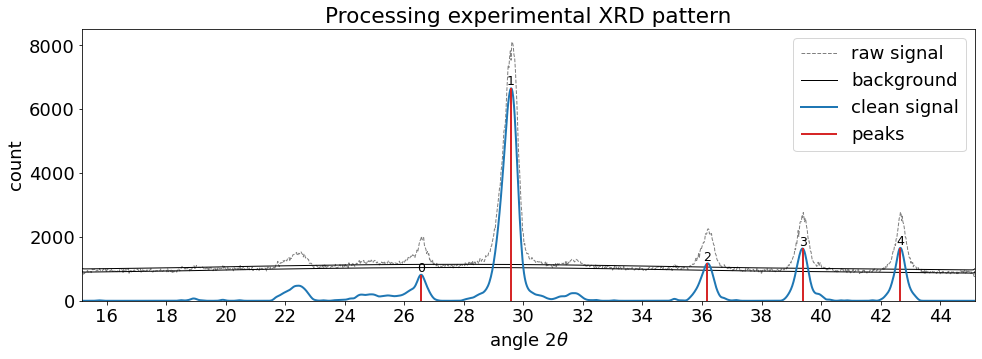

,Angle,Intensity
0,26.574,0.122
1,29.584,1.000
2,36.184,0.176
3,39.383,0.246
4,42.668,0.249


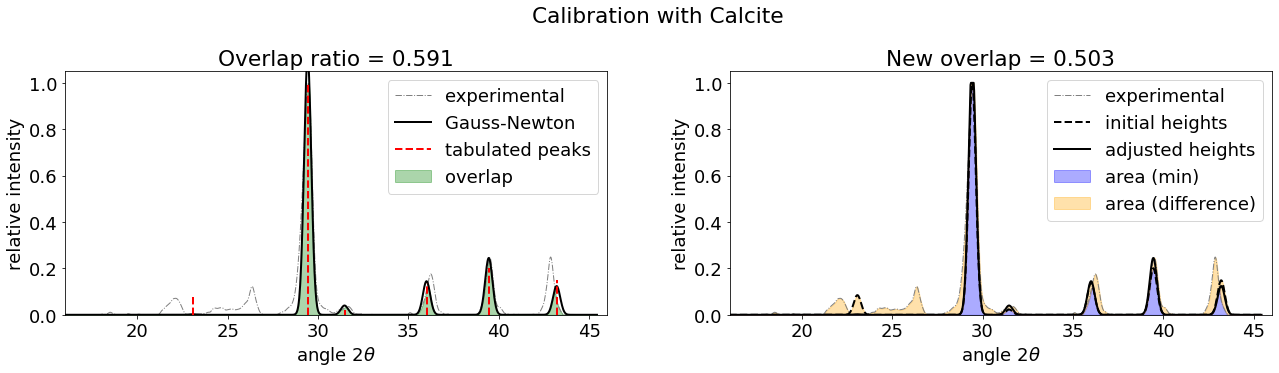

In [6]:
rcParams['font.size'] = 18

### Parameters for smoothing ###
window_snip = 60        # width of the window used for determining the background (default 32)
offset_background = 100   # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 3          # degree of the final smooth applied to the XRD pattern (default 0)

### Parameters for searching peaks ###
width_peak = 5   # Minimum width of the peaks, in channels (default 10)
height_peak = 0.13  # Minimum height of the peaks, between 0 and 1, compared against a logarithmic function of the XRD pattern

### Parameters for calibration ###
adjust_calibration = True
phase_calibration = database['Calcite'][0]


###


list_spectra_xrd = [
    FastSpectraXRD()
    .from_file(filename)
    .calibrate_from_file(file_calibration)
    .remove_background(window_snip = window_snip, offset_background = offset_background)
    .smooth_channels(std_kernel = std_smooth)
    for filename in list_filenames
]

list_gn = [
    GaussNewton(phase_calibration, spectrum, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
    for spectrum in list_spectra_xrd
]
if adjust_calibration:
    for gn in list_gn:
        gn.fit_cycle(steps = 16, gamma = True).fit_cycle(steps = 16, a = True, s = True, gamma = True).fit_cycle(steps = 16, gamma = True)

spectrum_xrd = list_spectra_xrd[0]
print(f'Data length: {spectrum_xrd.counts.shape[0]}')
print('Initial calibration:')
print(f'a = {spectrum_xrd.opt[0]:.1f}, s = {spectrum_xrd.opt[1]:.1f}, beta = {spectrum_xrd.opt[2]:.3f}')
print(f'Theta range {spectrum_xrd.theta_range()}')

signal_for_peaks = log(spectrum_xrd.intensity + 1)
signal_for_peaks /= signal_for_peaks.max()
peaks_position = find_peaks(signal_for_peaks, width = width_peak, height = height_peak)[0]
peaks_position_angle = spectrum_xrd.fce_calibration(peaks_position, *spectrum_xrd.opt)
peaks_intensity = spectrum_xrd.intensity[peaks_position]

fig, ax = subplots(figsize = (16, 5))
ax.plot(spectrum_xrd.theta, spectrum_xrd.counts, c = 'grey', ls = '--', lw = 1, label = 'raw signal')
ax.plot(spectrum_xrd.theta, spectrum_xrd.background, c = 'black', ls = '-', lw = 1, label = 'background')
ax.plot(spectrum_xrd.theta, spectrum_xrd.background + spectrum_xrd.offset_background, c = 'black', ls = '-', lw = 1)
ax.plot(spectrum_xrd.theta, spectrum_xrd.counts_smoothed, lw = 2, label = 'clean signal')
ax.vlines(peaks_position_angle, 0, spectrum_xrd.counts_smoothed[peaks_position], color = 'tab:red', lw = 2, label = 'peaks')
for i in range(len(peaks_position_angle)):
    text(peaks_position_angle[i], spectrum_xrd.counts_smoothed[peaks_position[i]], f'{i}', ha = 'center', va = 'bottom', fontsize = 'x-small')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xticks(arange(0, spectrum_xrd.theta_range()[1] + 0.001, 2))
ax.set_xlim(*spectrum_xrd.theta_range())
ax.set_ylim(0, None)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('count')
ax.set_title('Processing experimental XRD pattern')
show()

display(DataFrame({'Angle': peaks_position_angle, 'Intensity': peaks_intensity})
 .style.format({'Angle': '{:.3f}', 'Intensity': '{:.3f}'}))

###

if adjust_calibration:
    gn = list_gn[0]

    z0 = clip(gn.z0(), None, 1) # to avoid anomalously high peaks resulting from overlapping tabulated peaks
    z = clip(gn.z(), None, 1)
    intensity_corrected = maximum(gn.intensity, 0)
    z_stack = stack((z0, z, intensity_corrected))
    z_min = z_stack.min(axis = 0)
    z_max = z_stack.max(axis = 0)
    presence = z_min.sum() / z_max.sum()

    fig, axs = subplots(1, 2, figsize = (18, 5))
    fig.tight_layout(w_pad = 4)
    fig.subplots_adjust(top = 0.8)   # To shift the title

    ax = axs[0]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
    gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
    gn.plot_phase(lw = 2, alpha = 1, label = 'tabulated peaks')
    ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'Overlap ratio = {gn.overlap_area_ratio():.3f}')

    ax = axs[1]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
    ax.plot(gn.theta, z0, c = 'black', ls = '--', lw = 2, label = 'initial heights')
    ax.plot(gn.theta, z, c = 'black', ls = '-', lw = 2, label = 'adjusted heights')
    ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'area (min)')
    ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'area (difference)')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta - 1, max_theta + 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel('relative intensity')
    ax.set_title(f'New overlap = {gn.adjustment_ratio():.3f}')

    fig.suptitle(f'Calibration with {gn.label}')
    show()

### Compare all XRD patterns and check against a given tabulated phase

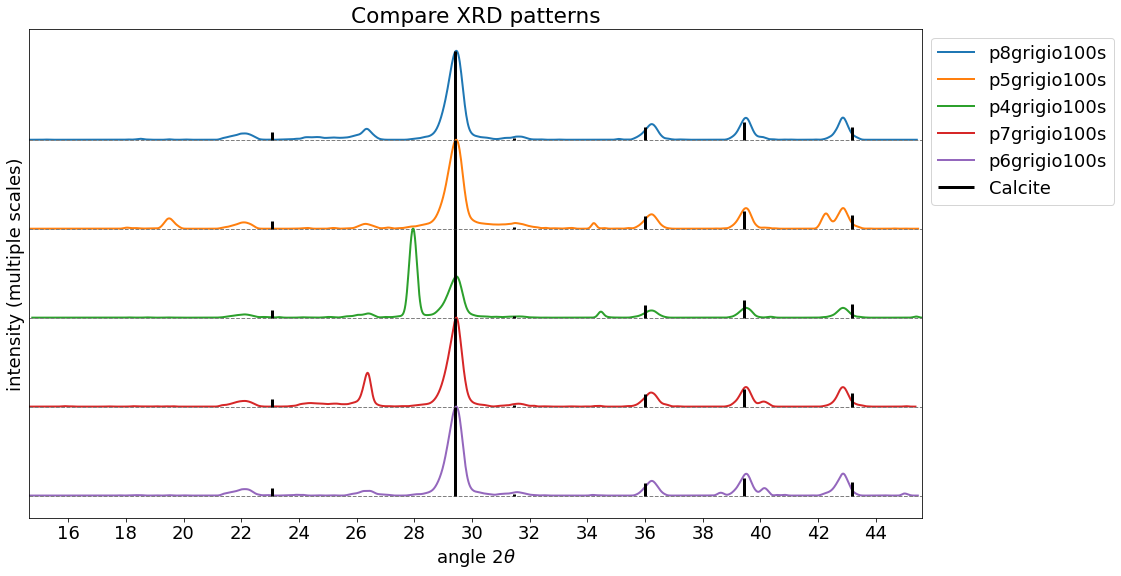

In [7]:
#phase_check = database['Calcite'][0]
phase_check = phase_calibration
#phase_check = None   # Use this if you don't want to check the XRD pattern against any tabulated phase

###

separation_vertical = 1
fig, ax = subplots(figsize = (16, 4 + len(list_spectra_xrd)))
for i, gn in enumerate(list_gn):
    y_shift = - separation_vertical * i
    ax.plot(gn.theta, gn.intensity + y_shift, lw = 2, label = dirname(relpath(list_filenames[i], start = path_multiple_points)))
    ax.axhline(y = y_shift, c = 'grey', ls = '--', lw = 1)
    if phase_check is not None:
        theta, intensity, _ = phase_check.get_theta(min_theta = min_theta, max_theta = max_theta,
            min_intensity = min_intensity, first_n_peaks = first_n_peaks, distance_merge = distance_merge)
        vlines(theta, y_shift, intensity * separation_vertical + y_shift, colors = 'black', lw = 3,
               label = phase_check.label if (i == len(list_gn) - 1) else None)
ax.yaxis.set_major_locator(NullLocator())
ax.legend(frameon = True, bbox_to_anchor = (1, 1), loc = 'upper left')
arr_theta_range = array([gn.theta_range() for gn in list_gn])
theta_min, theta_max = arr_theta_range[:, 0].min(), arr_theta_range[:, 1].max()
ax.set_xticks(arange(0, theta_max + 0.001, 2))
ax.set_xlim(theta_min, theta_max)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('intensity (multiple scales)')
ax.set_title('Compare XRD patterns')
show()